In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product
warnings.filterwarnings('ignore')

/var/folders/8t/_xbd4d4117l1s7h5p9tj9rxr0000gn/T/ipykernel_5242/1964029187.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
cb = pd.read_excel('CBA.AX5y.xls')

In [3]:
cb.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1262,2022-09-15,94.849998,95.339996,94.660004,95.059998,95.059998,3364419
1263,2022-09-16,94.550003,95.279999,94.044998,94.230003,94.230003,5980478
1264,2022-09-19,94.250000,95.029999,94.250000,94.660004,94.660004,1474030
1265,2022-09-20,95.949997,96.800003,95.660004,96.529999,96.529999,2389248
1266,2022-09-21,96.279999,96.279999,95.750000,95.860001,95.860001,128860


In [4]:
cb.columns = cb.columns.str.lower()

In [5]:
cb.columns

Index(['date', 'open', 'high', 'low', 'close', 'adj close', 'volume'], dtype='object')

In [6]:
cb['movement'] = cb['close'] - cb['open']

In [7]:
cb.tail()

,date,open,high,low,close,adj close,volume,movement
1262,2022-09-15,94.849998,95.339996,94.660004,95.059998,95.059998,3364419,0.210000
1263,2022-09-16,94.550003,95.279999,94.044998,94.230003,94.230003,5980478,-0.320000
1264,2022-09-19,94.250000,95.029999,94.250000,94.660004,94.660004,1474030,0.410004
1265,2022-09-20,95.949997,96.800003,95.660004,96.529999,96.529999,2389248,0.580002
1266,2022-09-21,96.279999,96.279999,95.750000,95.860001,95.860001,128860,-0.419998


In [8]:
cb.date = pd.to_datetime(cb['date'], format=None)

In [9]:
cb.dtypes

date         datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
adj close           float64
volume                int64
movement            float64
dtype: object

In [10]:
comm = cb.drop(labels = ['open', 'high', 'low', 'close', 'adj close', 'volume'], axis=1)

In [11]:
comm.set_index('date',inplace=True)

In [12]:
comm.head()

,movement
date,
2017-09-21,0.070000
2017-09-22,0.420006
2017-09-25,-1.220001
2017-09-26,-0.700005
2017-09-27,-0.230004


In [13]:
comm.isnull().sum()

movement    0
dtype: int64

<AxesSubplot:xlabel='date'>

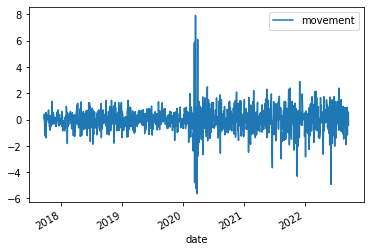

In [14]:
comm.plot()

### Moving Average

In [15]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    

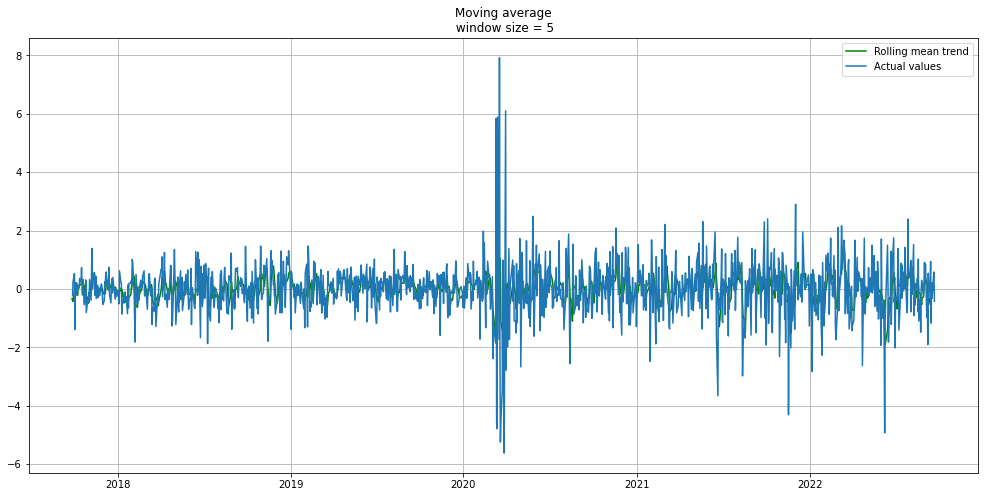

In [16]:
#Smooth by the previous 5 days (by week)
plot_moving_average(comm.movement, 5)

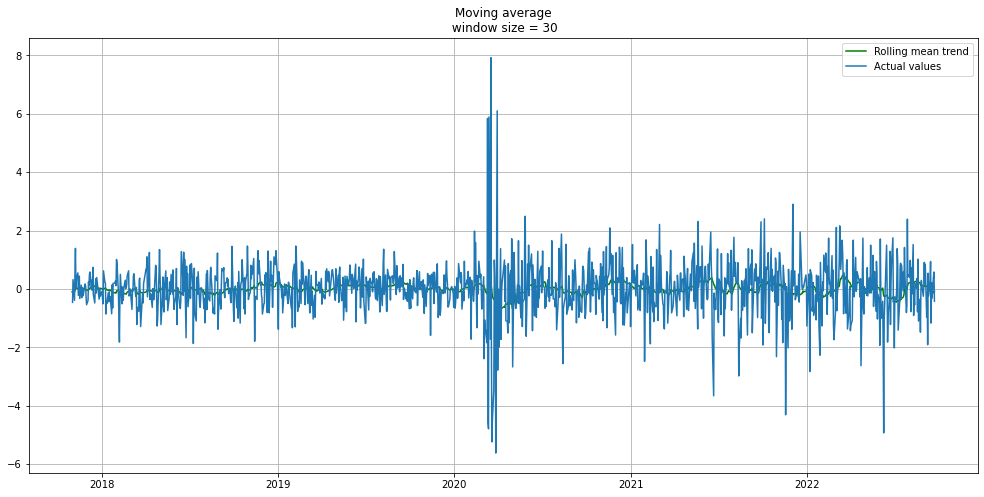

In [17]:
#Smooth by the previous month (30 days)
plot_moving_average(comm.movement, 30)

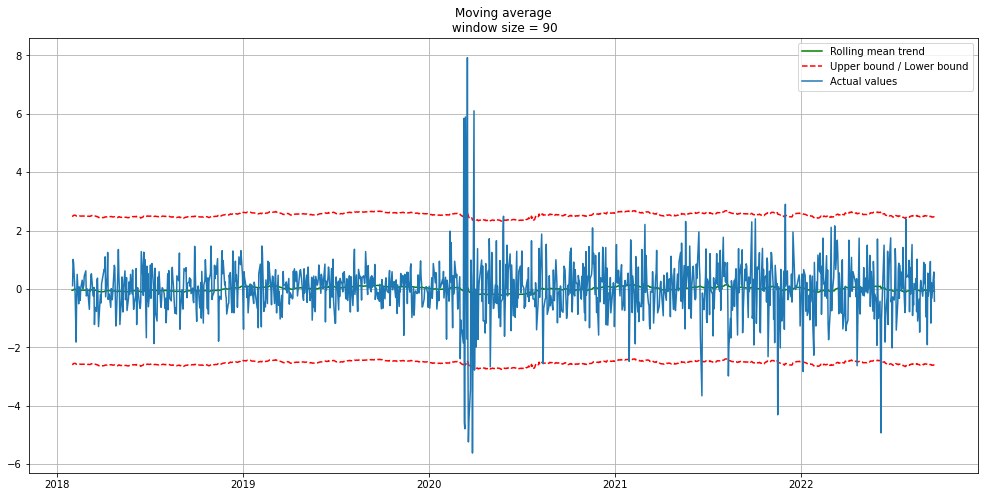

In [18]:
#Smooth by previous quarter (90 days)
plot_moving_average(comm.movement, 90, plot_intervals=True)

### Exponential smoothing

In [19]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);



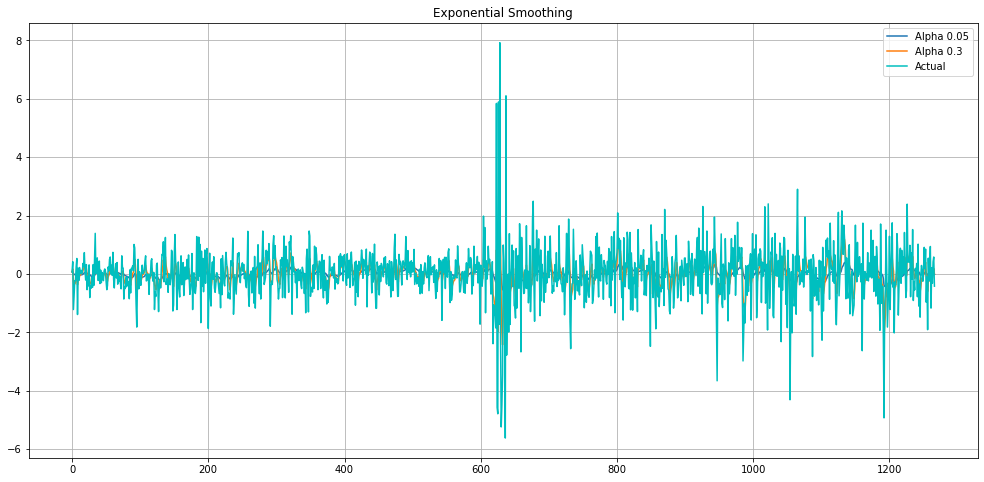

In [20]:
plot_exponential_smoothing(comm.movement, [0.05, 0.3])

### Double exponential smoothing

In [21]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

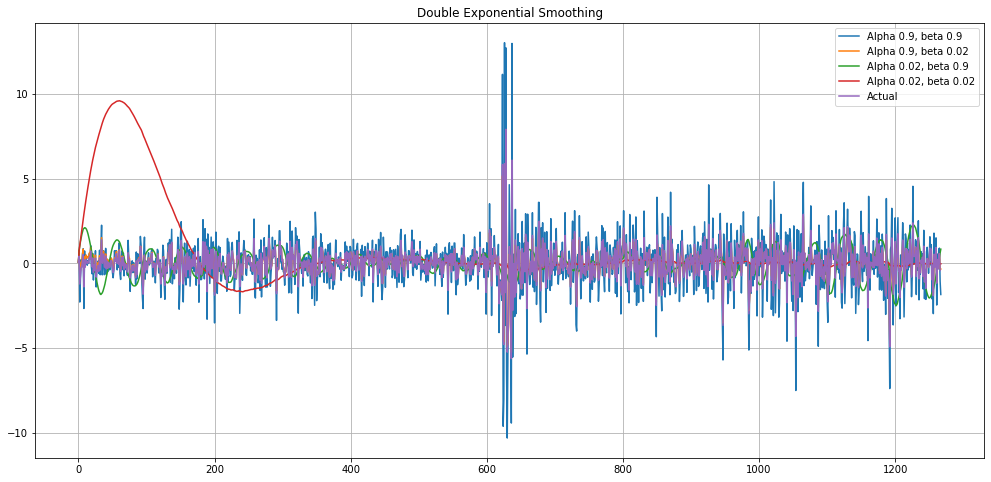

In [22]:
plot_double_exponential_smoothing(comm.movement, alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Modelling

### Turn data series into Stationary using Dickey-Fuller test

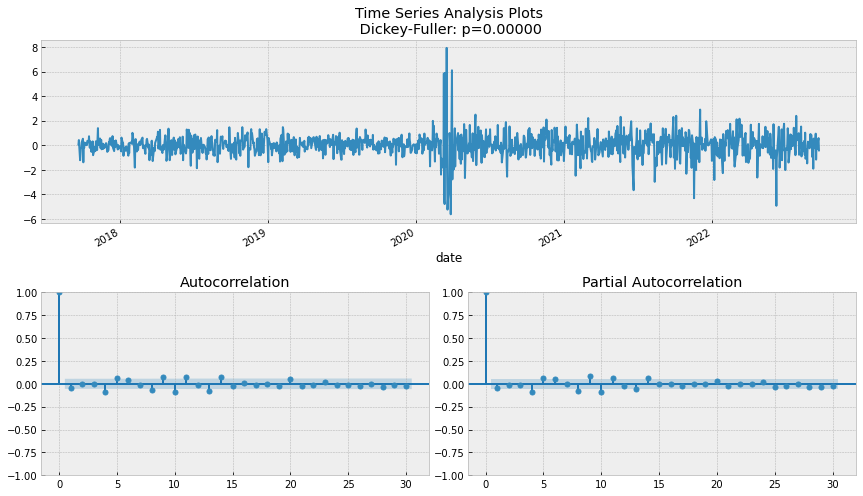

In [23]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(comm.movement, lags=30)


#### Our data is now stationary and ready for modelling

### SARIMA

In [42]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(comm.close, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(comm.close, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

  0%|          | 0/625 [00:00<?, ?it/s]

                                         SARIMAX Results                                         
Dep. Variable:                                     close   No. Observations:                 1434
Model:             SARIMAX(4, 1, 4)x(1, 1, [1, 2, 3], 5)   Log Likelihood                   0.000
Date:                                   Thu, 22 Sep 2022   AIC                             26.000
Time:                                           13:19:18   BIC                             94.432
Sample:                                                0   HQIC                            51.556
                                                  - 1434                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0403         -0        inf      0.000    

### Make Predictions

In [37]:
#SARIMAX(2, 1, 2)x(2, 1, [1], 5)
#SARIMAX(4, 1, 4)x(1, 1, [1, 2, 3], 5)
len(comm)


1267

In [61]:
comm.describe

<bound method NDFrame.describe of             movement
date                
2017-09-21  0.070000
2017-09-22  0.420006
2017-09-25 -1.220001
2017-09-26 -0.700005
2017-09-27 -0.230004
...              ...
2022-09-15  0.210000
2022-09-16 -0.320000
2022-09-19  0.410004
2022-09-20  0.580002
2022-09-21 -0.419998

[1267 rows x 1 columns]>

In [59]:
[test_comm]

[            movement
 date                
 2021-09-02 -0.129997
 2021-09-03  0.479995
 2021-09-06  0.850006
 2021-09-07  0.139999
 2021-09-08  1.339996
 ...              ...
 2022-09-15  0.210000
 2022-09-16 -0.320000
 2022-09-19  0.410004
 2022-09-20  0.580002
 2022-09-21 -0.419998
 
 [267 rows x 1 columns]]

In [26]:
train_comm = comm.iloc[:1000]
test_comm = comm.iloc[1000:]
mod = sm.tsa.statespace.SARIMAX(train_comm['movement'], order=(2,1,2), seasonal_order=(1,1,1,5))
res = mod.fit()
start = comm.index[len(train_comm)]
end = comm.index[len(train_comm) + len(test_comm) - 1] #index number starts from zero
prediction = res.predict(start, end).rename('Prediction')
ax = test_comm['movement'].plot(legend=True, figsize = (16,8))
prediction.plot(legend=True)
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85823D+00    |proj g|=  6.96071D-01

At iterate    5    f=  1.59581D+00    |proj g|=  5.13941D-02


 This problem is unconstrained.



At iterate   10    f=  1.39823D+00    |proj g|=  8.06221D-02

At iterate   15    f=  1.34332D+00    |proj g|=  1.27084D-02

At iterate   20    f=  1.33294D+00    |proj g|=  6.51962D-03

At iterate   25    f=  1.33222D+00    |proj g|=  1.78651D-03

At iterate   30    f=  1.33220D+00    |proj g|=  2.26389D-04

At iterate   35    f=  1.33220D+00    |proj g|=  4.82693D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     46      1     0     0   3.493D-05   1.332D+00
  F =   1.3322046371848555     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [56]:
[prediction]

[1000   -0.180582
 1001   -0.376699
 1002   -0.281836
 1003   -0.298170
 1004   -0.316035
           ...   
 1262   -0.368768
 1263   -0.385102
 1264   -0.402966
 1265   -0.269185
 1266   -0.465303
 Name: Prediction, Length: 267, dtype: float64]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68832D+00    |proj g|=  2.08748D-01

At iterate    5    f=  1.60928D+00    |proj g|=  1.28060D-01

At iterate   10    f=  1.58510D+00    |proj g|=  2.37679D-02

At iterate   15    f=  1.58260D+00    |proj g|=  5.72783D-03

At iterate   20    f=  1.58154D+00    |proj g|=  1.59821D-02

At iterate   25    f=  1.58102D+00    |proj g|=  7.92360D-03

At iterate   30    f=  1.58085D+00    |proj g|=  1.18147D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<AxesSubplot:>

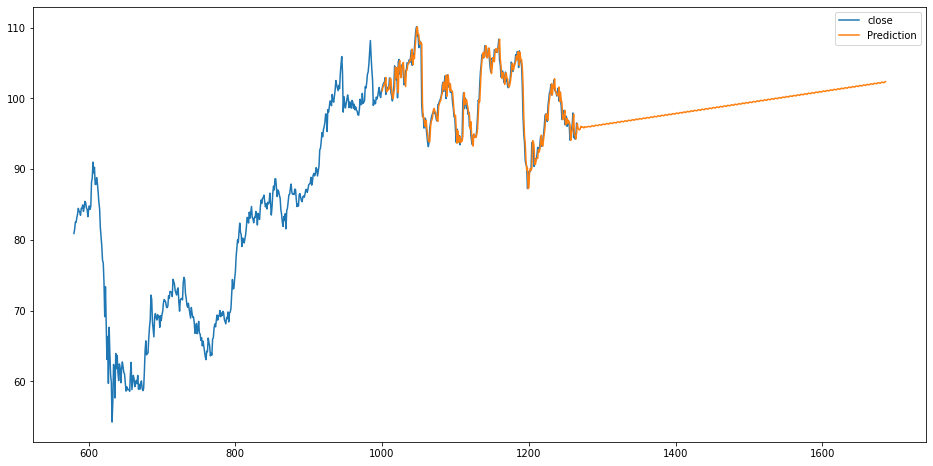

In [37]:
train_comm = comm.iloc[:1000]
test_comm = comm.iloc[580:]
mod = sm.tsa.statespace.SARIMAX(comm['close'], order=(2,1,2), seasonal_order=(2,1,1,5))
res = mod.fit()
start = len(train_comm)
end = len(train_comm) + len(test_comm) - 1 #index number starts from zero
prediction = res.predict(start, end).rename('Prediction')
ax = test_comm['close'].plot(legend=True, figsize = (16,8))
prediction.plot(legend=True)

19.085999063318322

In [39]:
from pandas.tseries.offsets import DateOffset

In [40]:
comm.tail()

,date,close
1262,2022-09-15,95.059998
1263,2022-09-16,94.230003
1264,2022-09-19,94.660004
1265,2022-09-20,96.529999
1266,2022-09-21,95.860001


In [44]:
commb = pd.concat([comm, fd], ignore_index=True)

In [45]:
commb.close = commb.close.astype(float)

In [46]:
commb.tail(10)

,date,close
2524,2022-09-15,NaN
2525,2022-09-16,NaN
2526,2022-09-19,NaN
2527,2022-09-20,NaN
2528,2022-09-21,NaN
2529,2022-09-22,NaN
2530,2022-09-23,NaN
2531,2022-09-26,NaN
2532,2022-09-27,NaN
2533,2022-09-28,NaN


In [47]:
fdates = pd.DataFrame(pd.date_range(comm["date"].min(), comm["date"].max() + pd.DateOffset(days=7))
,columns=['future_date'])

df_new = pd.concat([comm,fdates],axis=1)

In [50]:
fdates.tail(10)

,future_date
1824,2022-09-19
1825,2022-09-20
1826,2022-09-21
1827,2022-09-22
1828,2022-09-23
1829,2022-09-24
1830,2022-09-25
1831,2022-09-26
1832,2022-09-27
1833,2022-09-28


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83851D+00    |proj g|=  4.67167D-01

At iterate    5    f=  1.44240D+00    |proj g|=  7.48350D-02

At iterate   10    f=  1.38514D+00    |proj g|=  2.59458D-02

At iterate   15    f=  1.36331D+00    |proj g|=  8.61408D-03

At iterate   20    f=  1.36113D+00    |proj g|=  1.26618D-02

At iterate   25    f=  1.35910D+00    |proj g|=  1.85535D-03

At iterate   30    f=  1.35876D+00    |proj g|=  4.94069D-03

At iterate   35    f=  1.35843D+00    |proj g|=  1.31622D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<AxesSubplot:>

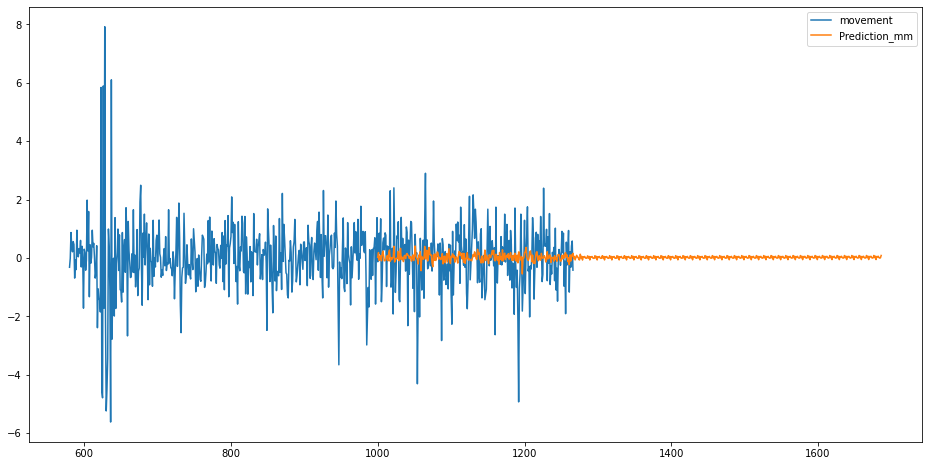

In [52]:
train_mm = mm.iloc[:1000]
test_mm = mm.iloc[580:]
model = sm.tsa.statespace.SARIMAX(mm['movement'], order=(2,1,2), seasonal_order=(2,1,1,5))
res = model.fit()
start = len(train_mm)
end = len(train_mm) + len(test_mm) - 1 #index number starts from zero
prediction = res.predict(start, end).rename('Prediction_mm')
ax = test_mm['movement'].plot(legend=True, figsize = (16,8))
prediction.plot(legend=True)